In [1]:
#!/usr/bin/env python
# ============================================================
#  SITS-BERT  ·  California-Labeled  ·  6-band data prep
# ------------------------------------------------------------
#  Reads  : /kaggle/input/california-labeled/{Train,Validate,Test}.csv
#  Writes : /kaggle/working/data/6_features_{Train,Validate,Test}.csv
# ------------------------------------------------------------
#  Each output row = 24 × 7 floats  (B1-6 + DOY)  +  label
# ============================================================

import csv, subprocess, sys, shutil, random
from pathlib import Path
import numpy as np

In [2]:
# ───────────────────────────────────
# 0 · CONFIG
# ───────────────────────────────────
SEED       = 42
SRC_DIR    = Path("/kaggle/input/california-labeled")
DST_DIR    = Path("/kaggle/working/data")
SITS_REPO  = Path("/kaggle/working/SITS-BERT")


In [3]:
!git clone -q https://github.com/linlei1214/SITS-BERT.git

In [4]:
!ls SITS-BERT/checkpoints/pretrain/

checkpoint.bert.pth


In [5]:
!mkdir checkpoints_finetune

In [6]:
!python /kaggle/working/SITS-BERT/code/finetuning.py \
  --file_path /kaggle/input/california-labeled/ \
  --pretrain_path SITS-BERT/checkpoints/pretrain/ \
  --finetune_path /kaggle/working/checkpoints_finetune/ \
  --num_features 10 \
  --max_length 64 \
  --num_classes 13 \
  --epochs 100 \
  --batch_size 128 \
  --hidden_size 256 \
  --layers 3 \
  --attn_heads 8 \
  --learning_rate 2e-4 \
  --dropout 0.1

2025-06-20 00:36:52.628656: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750379812.825699      88 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750379812.886379      88 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Loading Data sets...
training samples: 1300, validation samples: 1300, testing samples: 318588
Creating Dataloader...
Initialing SITS-BERT...
Loading pre-trained model parameters...
Creating Downstream Task Trainer...
Fine-tuning SITS-BERT...
EP0, train_OA=23.38, train_Kappa=0.170, validate_OA=43.46, validate_Kappa=0.388
EP:0 Model Saved on: /kaggle/working/checkpoints_finetune/checkpoint.tar
EP1, train_OA=53.31, train_Kappa=0.494, v

✅ Loaded 318,588 samples (10-band + DOY × 64, 13 classes)
✅ Checkpoint loaded: /kaggle/working/checkpoints_finetune/checkpoint.tar

              precision    recall  f1-score   support

           0     0.9171    0.9800    0.9475      3804
           1     0.9644    0.9778    0.9710     24301
           2     0.5844    0.9830    0.7330      2180
           3     0.9518    0.9687    0.9602     14623
           4     0.9334    0.9993    0.9653     13192
           5     0.9206    0.9090    0.9148     66592
           6     0.9280    0.9240    0.9260     11741
           7     0.9624    0.8935    0.9267     53761
           8     0.8588    0.9220    0.8892     14352
           9     0.4631    0.7863    0.5829      1666
          10     0.9452    0.9997    0.9717      2968
          11     0.9887    0.9747    0.9817     74918
          12     0.9421    0.9456    0.9439     34490

    accuracy                         0.9402    318588
   macro avg     0.8738    0.9434    0.9011    318588
we

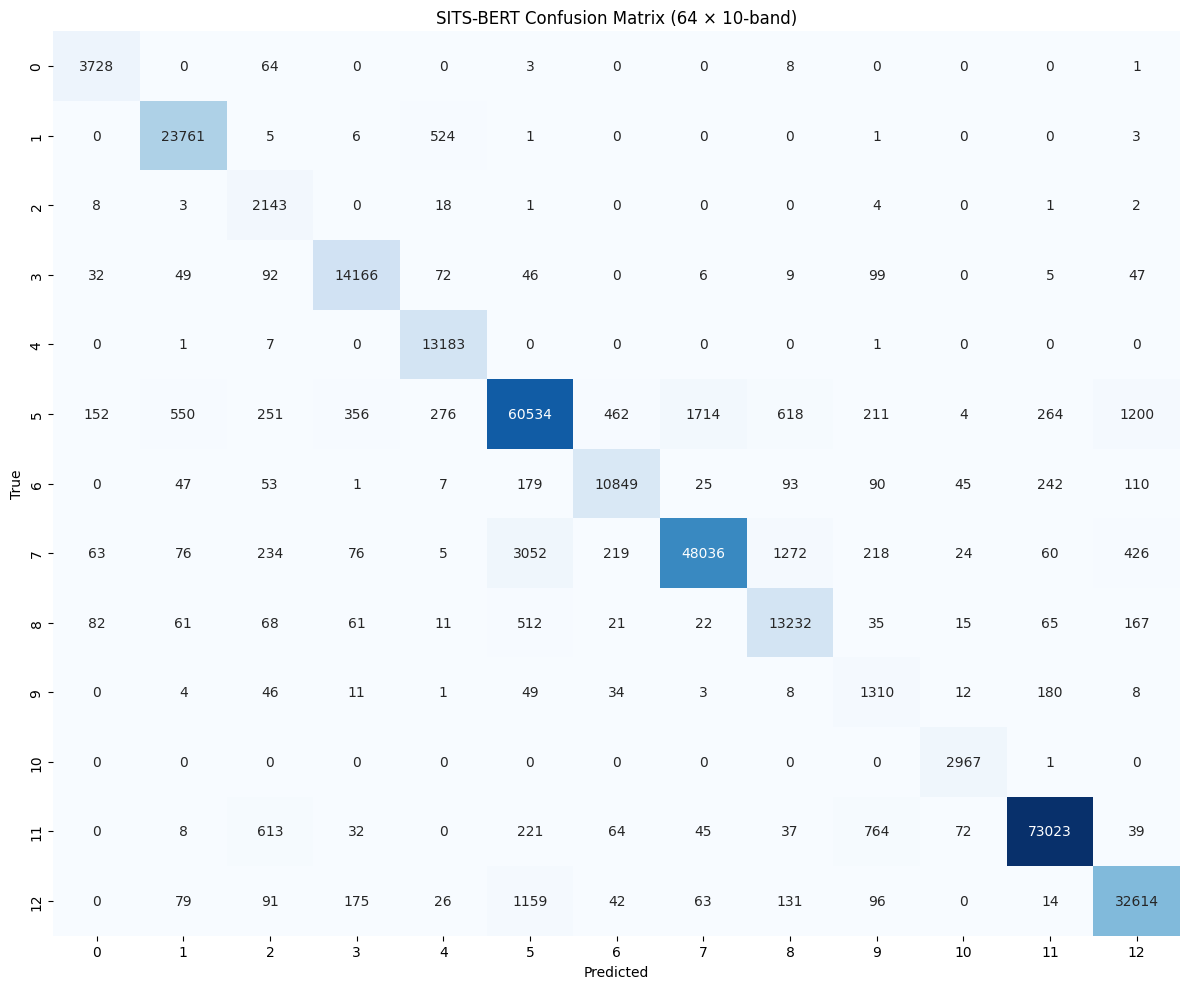

In [10]:
# evaluate_v2.py  –  64 steps · 10 spectral bands + DOY
import sys, inspect, csv, numpy as np, torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# ───────────────────────────── Configuration ──────────────────────────────
ROOT       = Path("/kaggle/working")
CSV_TEST   = Path("/kaggle/input/california-labeled/Test.csv")         # ← NEW
CKPT_FILE  = ROOT / "checkpoints_finetune" / "checkpoint.tar"
SITS_REPO  = ROOT / "SITS-BERT" / "code"
BATCH_SIZE = 128
SEQ_LEN    = 64                                             # ← NEW
DEVICE     = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ─────────── Add repo to path & import ────────────────────────────────────
sys.path.append(str(SITS_REPO))
from model.classification_model import SBERTClassification
from model.bert                 import SBERT

# ─────────── Build SBERT helper ──────────────────────────────────────────
_sig = inspect.signature(SBERT.__init__)
def make_sbert(num_features: int) -> torch.nn.Module:
    base = dict(
        num_features = num_features,
        hidden       = 256,
        n_layers     = 3,
        attn_heads   = 8,
        dropout      = 0.1,
    )
    kwargs = {k: v for k, v in base.items() if k in _sig.parameters}
    missing = [
        p.name for p in _sig.parameters.values()
        if p.default is inspect._empty and p.name not in kwargs and p.name != "self"
    ]
    if missing:
        raise RuntimeError(f"❌ Missing SBERT init args: {missing}")
    return SBERT(**kwargs)

# ─────────── Dataset ──────────────────────────────────────────────────────
# ─────────── Dataset ──────────────────────────────────────────────────────
class SITSCSVDataset(Dataset):
    def __init__(self, path: Path, seq_len: int = 64):
        # -------------------- ingest one CSV -------------------------------
        rows   = list(csv.reader(path.open()))
        n_feat = 11                           # 10 spectral bands + DOY
        spec   = n_feat - 1                   # = 10

        X, D, Y = [], [], []
        for r in rows:
            if not r:
                continue
            floats = np.asarray(r[:-1], dtype=np.float32)
            if (floats.size % n_feat) != 0:
                continue                      # corrupt line → skip

            T_full = floats.size // n_feat
            seq    = floats.reshape(n_feat, T_full).T   # [T_full, 11]

            # ---- pad or truncate to desired length ------------------------
            if T_full < seq_len:                          # pad
                pad = np.zeros((seq_len - T_full, n_feat), dtype=seq.dtype)
                seq = np.vstack([seq, pad])
            elif T_full > seq_len:                        # truncate
                seq = seq[:seq_len]

            X.append(seq[:, :spec])                       # spectral (10)
            D.append(seq[:,  spec].astype(np.int64))      # DOY
            Y.append(int(r[-1]))

        # -------------------- tensors on CPU --------------------------------
        self.x   = torch.tensor(np.stack(X) / 1e4, dtype=torch.float32)  # [N, 64, 10]
        self.doy = torch.tensor(np.stack(D))                             # [N, 64]
        self.y   = torch.tensor(Y, dtype=torch.long)                     # [N]

        print(f"✅ Loaded {len(self):,} samples "
              f"(10-band + DOY × {seq_len}, {int(self.y.max()+1)} classes)")

    # --------- ⚠️  THESE TWO LINES WERE MISSING ----------------------------
    def __len__(self):                          # now len(ds) works
        return self.y.size(0)

    def __getitem__(self, idx):                 # DataLoader can index
        return self.x[idx], self.doy[idx], self.y[idx]



# ─────────── Evaluation ───────────────────────────────────────────────────
# 1) Load data
ds     = SITSCSVDataset(CSV_TEST, SEQ_LEN)
loader = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=False)

# 2) Build model & send to device
sbert = make_sbert(ds.x.size(-1))                # 10 features
model = SBERTClassification(sbert, int(ds.y.max()+1)).to(DEVICE)

# 3) Strictly load checkpoint
ckpt = torch.load(CKPT_FILE, map_location=DEVICE)
res  = model.load_state_dict(ckpt["model_state_dict"], strict=True)
print("✅ Checkpoint loaded:", CKPT_FILE)
if res.missing_keys:
    print("⚠️ Missing keys:", res.missing_keys)
if res.unexpected_keys:
    print("⚠️ Unexpected keys:", res.unexpected_keys)

model.eval()

# 4) Get positional-embedding size & clamp DOY
pe_size = model.sbert.embedding.position.pe.size(0)

# 5) Inference
y_true, y_pred = [], []
with torch.no_grad():
    for xb, doy, yb in loader:
        xb  = xb.to(DEVICE)
        doy = torch.clamp(doy.to(DEVICE).long() - 1, 0, pe_size - 1)
        mask = torch.ones(xb.size(0), SEQ_LEN, dtype=torch.bool, device=DEVICE)

        logits = model(xb, doy, mask)
        y_pred.extend(logits.argmax(dim=1).cpu().tolist())
        y_true.extend(yb.tolist())

# 6) Classification report
print("\n" + classification_report(
    y_true, y_pred, digits=4, zero_division=0
))

# 7) Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
try:
    import seaborn as sns
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
except ImportError:
    plt.imshow(cm, interpolation="nearest", aspect="auto")
plt.title("SITS-BERT Confusion Matrix (64 × 10-band)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout()
plt.show()
